# Document indexing with LSH Forest

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2016 Florian Leitner. All rights reserved.

## Introduction

Today's lab will cover the two most fundamental techniques of Text Mining: Document classification and indexing; This notebook covers the latter ("building the world's fastest search engine").

For background, please check the "Pitfalls for budding data scientists" and the "Shingling and Jaccard's similarity" notebooks.

An excellent resource for basic LSH is the free book (PDF) by Rajaraman, ["Mining of Massive Datasets"](http://infolab.stanford.edu/~ullman/mmds/book.pdf). We will specifically be looking at a "self-tuning" LSH design, the [LSH Forest by Bawa et al.](http://infolab.stanford.edu/~bawa/Pub/similarity.pdf) Another design variant of this hashing technique is [LSH Ensemble by Zhu et al.](http://www.vldb.org/pvldb/vol9/p1185-zhu.pdf), which is designed to use LSH on a short (query) sequence lookup against long (document) sequences by modifying similarity to only use the length of the query in the denominator. LSH Ensemble is therefore is a nice simple approach to an ranked IR system "on the cheap" and without having to fall back on a pairwise ranking strategy to come up with the most similar matches to the query first. But as we will be using *documents* as our queries, though, we will focus on LSH Forest here.

Ensure you have **NLTK** installed or install it with:

- Anaconda Python: `conda install nltk`
- Stock Python: `pip3 install nltk`

Also install the `segtok` tokenization and segmentation library created by yours truly (the instructor, me):

- Anaconda Python: `conda install segtok`
- Stock Python: `pip3 install segtok`

Once done, the following imports should work; If not, you can always skip the practical document indexing examples below.

Once done, the following imports should work; If not, you can always skip the practical example at the end.

In [1]:
import nltk
import segtok
import sklearn

Ensure you have at least NLTK book (and/or popular) downloaded and installed from the dialog window that shows up.

In [2]:
#nltk.download()

In [3]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Jaccard's set similarity

(see the relevant Notebook for a detailed discussion)

In [4]:
def jaccard(seq1, seq2):
    """
    The Jaccard similarity between two sequences:
    |∩(X,Y)| / |∪(X,Y)|
    """
    
    x = set(seq1)
    y = set(seq2)
    return len(x & y) / len(x | y)

## Min-hash signatures

(see the "Pitfalls..." Notebook for a discussion of `hash` vs. `id`)

We will look into an implementation of LSH by [Christian Jauvin](http://cjauvin.github.io/); see [github.com/go2starr/lshhdc](https://github.com/go2starr/lshhdc) for educational puposes (but note that SciKit-Learn will provide us with the implementation we will be using).

In [5]:
class MinHashSignature:
    """Hash signatures for sets/tuples using minhash."""

    def __init__(self, size):
        """
        Define the size of the hash pool
        (number of hash functions).
        """
        
        self.size = size
        self.hashes = self.__gen_hash_functions()

    def __gen_hash_functions(self):
        """
        Return a list of `size` different hash functions.
        """
        
        def hash_factory(mutator):
            # note that each element in 
            # an item from a seq being min-hashed
            # will be pushed in here
            # I.e., item typically is a token,
            # character, n-gram, etc.
            return lambda item: hash(
                "salt" + str(mutator) + str(item) + "salt"
            )
        
        return [ hash_factory(m) for m in range(self.size) ]

    def sign(self, seq):
        """
        Return the min-hash signatures
        for any iterable input `seq`.
        """
        
        signature = [ float("inf") ] * self.size
        
        for idx, hash_function in enumerate(self.hashes):
            # min-hashing the input seq:
            # for each hash_function generated,
            # choose the hash value (ID)
            # (from hashing all the input sequence
            # with that hash function)
            # that has the smallest (i.e., min) value
            # as the value for the final signature
            signature[idx] = min(hash_function(item) for item in seq)
        
        return signature

Here is an example of a min-hash signature instance that generates four different hash values (signature size). This signature can be understood as generating four different, random orderings of the (whole) "possible" input vocabulary (if you like, "hash-permuted row IDs" of your complete vocabulary). The signature therefore reports the first matching token in the input sequence for each of the size different orderings over the whole vocabulary (not just the words in that document!).

In [6]:
sig4 = MinHashSignature(4)
sig4.sign(["this", "is", "an", "example", "document"])

[-7706907317463682804,
 -5605639870768415415,
 -6223539463645503589,
 -6589356995171225446]

## Banded Locality Sensitive Hashing

(see the "Pitfalls..." Notebook for a discussion of floating point issues with probabity values)

In [7]:
class BandedLSH:
    # n. bands (n. hash tables):
    # b = dictionary.hasher.size /
    #     dictionary.hasher.bandwidth
    #    
    # n. hashes per band:
    # r = dictionary.hasher.bandwidth 
    
    def __init__(self, size, threshold):
        """
        Set up targeting a Jaccard similarity `threshold`
        using the given min-hash signature `size`.
        """
        
        # total size (n. rows) of the matrix
        # (slide "Banded locality sensitve hasing")
        self.size = size
        # *desired* Jaccard similarity threshold
        # of the items belonging together
        self.threshold = threshold
        # number hashes to use per band
        # to get as close to that threshold as possible
        # bandwidth is the "rows per band"
        self.bandwidth = self.get_bandwidth(
            size,
            threshold)
        self.min_hasher = MinHashSignature(size)

    @staticmethod
    def get_bandwidth(n, t):
        """
        Approximate the bandwidth
        (number of rows in each band)
        for a fixed total number of
        rows `n` (bandwith * n. bands)
        needed to achieve the desired
        similarity threshold `t`.

        Similarity threshold t = (1. / b) ** (1. / r)
        with size (total rows in LSH) n = b * r
        where:
        b = number of bands
        r = number of rows per band
        therefore:
        b = 1 / (t ** r)
        and:
        r = n /b
        """
        
        best = n # default: 1 band with `n` rows
        minerr = float("inf") # default: "infinite" error
        
        # Try finding the smallest possible bandwith r
        # by starting with one row per band, etc:
        for r in range(1, n + 1):
            try:
                # calculate the number of bands b needed to
                # achieve the desired threshold t with the
                # current number of rows r
                b = 1. / (t ** r)
            except: # Divide by zero -> `size` is too big
                return best
            
            # how close would the calculated number bands b
            # with the current bandwith r, 
            # required to achieve the desired threshold t,
            # be to the desired total LSH size n?
            err = abs(n - b * r)
            
            if err < minerr:
                best = r
                minerr = err
                
        return best

    def hash(self, seq):
        """
        Generate one locality-sensitive hash ID for each band,
        from the input sequence `seq` (tokens, n-grams, etc.).
        """
        sig = self.min_hasher.sign(seq)
        
        for band in zip(*(iter(sig),) * self.bandwidth):
            # the "salt" is to make this approach more robust
            # and is specific to how hashing works (out of scope here)
            # this final hash is only used to only return 
            # one unique bucket it per band;
            # the `band` itself is a list of `bandwith`
            # integers from the signature
            yield hash("salt" + str(band) + "tlas")

    @property
    def exact_threshold(self):
        """
        The actual threshold,
        as defined by the calculated bandwith.
        """
        
        r = self.bandwidth
        b = self.size / r
        return (1. / b) ** (1. / r)

    @property
    def n_bands(self):
        """
        Calculate the number of bands.
        """
        
        return int(self.size / self.bandwidth)

The zip-list iterated over in BandedLSH.hash is simply to generate the signature hash ID subset for each band. E.g., assuming size = 6 for the BandedLSH and, therefore, also for the min-hash signature, and assuming the chosen bandwidth would be, say, 2 (from BandedLSH.get_bandwidth), the cryptical iterator zip(*(iter(sig),) * self.bandwidth) above would produce:

In [8]:
signature = [1,2,3,4,5,6]
bandwidth = 2
list(zip(*(iter(signature),) * bandwidth))

[(1, 2), (3, 4), (5, 6)]

Therefore, what we get out of BandedLSH.hash is one hash ID value for each band given an item's (min-hash) signature size and Jaccard simlilarty threshold target, by calculating the best bandwidth given those two input parameters:

In [9]:
hasher = BandedLSH(300, 0.1)
print("bandwidth calculated:", hasher.bandwidth)
print("resulting n. bands:", hasher.n_bands)
print("exact similarity threshold:", hasher.exact_threshold)

bandwidth calculated: 2
resulting n. bands: 150
exact similarity threshold: 0.08164965809277261


Pay attention to bandwidth (and the number of bands, too). This indicates how "hard" the threshold can be cut off. If the bandwidth is very small and the bands very large, you might rather fuzzy clusters (and a very streched sigmoid in the plot below). The bandwidth (rows/band) is proportional to the (desired) Jaccard similiarty (the horizontal position of the sigmoid plotted below).

To visualize the "cutoff hardness" of your setup, you can visualize the probability of two documents being added to the same cluster (i.e., set of buckets) as a function of their Jaccard similarity. (see slide "Banded Locaility Sensitive Minhashing", $p_{agreement}$)

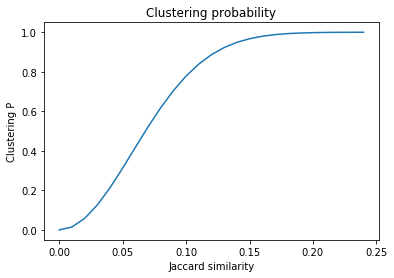

In [10]:
bands = 150
bandwidth = 2
p_agreement = lambda sim: 1 - (1 - sim**bandwidth)**bands
x = np.arange(0.0, 0.25, 0.01)

plt.plot(x, p_agreement(x))
plt.title('Clustering probability')
# (as a function of bandwidth and n. bands)
plt.xlabel('Jaccard similarity')
plt.ylabel('Clustering P')
plt.show()

Feel free to play around with the above cell, chaning `bandwidth` and `bands` to understand how those two parameters influnce the likelihood of two documents sharing *at least one bucket* given their Jaccard similarity.

## Document indexing

While the toy implementation above was practical to discuss the algorithm, we will be using a special [LSH **Forest**](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LSHForest.html#sklearn-neighbors-lshforest) implementation to retrieve the closest matching document given a query (document).

![title](img/lsh_forest.png)

Another attractive LSH implemention is avaliable from the [`datasketch`](https://ekzhu.github.io/datasketch/lsh.html) Python library.

### Corpus preparation

In [11]:
from sklearn.datasets import fetch_20newsgroups

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from segtok.segmenter import split_multi
from segtok.tokenizer import word_tokenizer, split_contractions

stemmer = PorterStemmer()
train, test = fetch_20newsgroups(), fetch_20newsgroups(subset='test')

stopwords_en = frozenset(stopwords.words('english'))
stopwords_none = frozenset([])


def tokenize(raw_text):
    """
    Convert text to lower-case tokens of length > 2.
    """
    
    for sentence in split_multi(raw_text):
        for raw in split_contractions(word_tokenizer(sentence)):
            token = raw.lower()
            
            if len(token) > 2 and any(c.isalnum() for c in token):
                yield token

                
def filter_and_stem(raw_text, stopwords):
    
    for token in tokenize(raw_text):
        yield token
        if token not in stopwords:
            yield stemmer.stem(token)
        else:
            yield None
                
                
def shingle(
    raw_text,
    stopwords=stopwords_none,
    bigrams=False):
    """
    Shingle text to stop-word-free,
    stemmed uni- and bi-grams.
    """
    
    last = None
    
    for t in filter_and_stem(raw_text, stopwords):
        if t is not None:
            yield t
            
            if bigrams and last is not None:
                yield "{}_{}".format(last, t)
            
        last = t

print("Corpus sizes: train =",
      len(train.data),
      "; test =", len(test.data))

Corpus sizes: train = 11314 ; test = 7532


Let's have a look at how that tokenization/shingling works on a document in our collection:

In [12]:
example = train['data'][0].strip()
print(example)

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----


In a real-world scenario, you'd probably start cleaning up the above "mess", removing the header and possibly the footers from the messages.

You can either use `tokenize` to work with single tokens, or `shingle` to work with [higher] n-grams and stopword-filtering, too.

In [13]:
tokens = frozenset(shingle(example))
print(" ".join(tokens))

from saw car looked funky separate whatev line organ there park tellm thank engine wondering nntp-posting-host rac3.wam.umd.edu can neighborhood 2-door thanks what made body model rest door your 70s the history university really look 60s lines thing know please e-mail univers thi bodi wonder anyone all histori sport front info engin organization separ anyon 60 out were 70 day specs years subject addition production funki this year addit colleg other doors bumper product wam.umd.edu whatever late wa earli sports realli pleas could bricklin college enlighten small where have lerxst looking early called brought was name call spec maryland you tellme


Now convert the whole 20News *train* corpus into tokens - this can take a while (possibly 5 minutes!) on most machines.

In [14]:
%time corpus = [frozenset(shingle(doc)) for doc in train['data']]

CPU times: user 2min 7s, sys: 668 ms, total: 2min 7s
Wall time: 2min 8s


### Similarity threshold estimation

First, we'd like to find out how our document similarity behaves across our corpus.
To do that we select a random "target" document and compute it's Jaccard similiary against all other documents.

other doc with max. Jaccard similarity = 0.3722627737226277
Mean Jaccard similarity = 0.0795601381685
Median Jaccard similarity = 0.07936507936507936


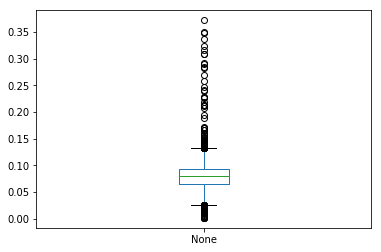

In [15]:
import pandas as pd
import random

target = random.choice(range(len(corpus)))
others = [i for i in range(len(corpus)) if i != target]
jsim = lambda i: jaccard(corpus[target], corpus[i])
max_sim = max((jsim(i) for i in others))

print("other doc with max. Jaccard similarity =",
      max_sim)

sims = pd.Series(jsim(i) for i in others)
print("Mean Jaccard similarity =", sims.mean())
print("Median Jaccard similarity =", sims.median())
sims.plot.box()

Rerun the above cell a few times to get a feeling for the similarty.

What you can see is that "plain" LSH will *not* be very useful for **clustering** our corpus (represented as _bags-of-words_), because most documents have a very low similiarty to each other.
Rather, where LSH shines is detecting duplicates or even plagiarism, because then the Jaccard simliarity is (very) high.

### LSH Forest setup

A special variant of LSH, LSH *Forest*, is able to detect the best match for a query (document) if there is any reasonable Jaccard similarity between that query and some document in your collection.
In addition, and as before for the document classification, we set up a TF-IDF document vectorizer.

In [24]:
%%time

from sklearn.neighbors import LSHForest
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    max_df=0.5,
    #ngram_range=(1,2),
    token_pattern='(?u)(?:\\b|(?<=_))[^\W_][^\W_]+(?:\\b|(?=_))',
)
# train (aka, fit) the vectorizer to the train data:
X_train = vectorizer.fit_transform(train.data)

classifier = LSHForest(n_estimators=30, n_neighbors=1000)
classifier.fit(X_train)

CPU times: user 5.72 s, sys: 163 ms, total: 5.88 s
Wall time: 5.9 s


Great, we've indexed all our documents in virtually no time! Please let this sink in for a moment - most search engines spend ages indexing content, while this solution hardly spends any noticable time at all (compared to the collection size, over 11,000 documents). This property of LSH is *extremely* useful when working with document streams where you don't have much time to process each document!

The parameter that has the strongest impact on indexing *and, particularly,* search times is `n_estimators`, but increasing it improves the retrieval quality. Depending on your needs, you will almost certainly want to adjust that parameter to your use-case. The `n_neighbors` parameter only sets the default number of documents returned by a query, but makes the queries  not noticably slower. For the reamining parameters, please refer to the [SciKit-Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LSHForest.html#sklearn.neighbors.LSHForest).

## Document search

Now, lets use this classifier to predict the nearest neighbor-ranked list for each of the "test" documents that we did not yet index (so this isn't just trivially returning exact matches).

In [25]:
%%time

# with the fitted vectorizer, transform the test data:
X_test = vectorizer.transform(test.data)

# now run the queries:
indices = classifier.kneighbors(
    X_test,
    n_neighbors=1000,
    return_distance=False)

CPU times: user 1min 53s, sys: 4.72 s, total: 1min 58s
Wall time: 1min 58s


What is quite noteworthy here is the time it took to search our documents. We searched for around 7,000 documents in a pool of almost 12,000; So each query just took a small fraction of a second!

## Evaluation

Now we evaluate how good that index mechanism is.
We will query the index with our test documents, only retrieving the best match from the indexed training documents.
Then, we check if that retrieved training document indeed would have been the most similar document for that query document from the test set (in terms of Jaccard similarity).

That is, we will evaluate the (mean) *true* rank of the returned document from LSH Forest by ordering all *training* documents against the query document using the Jaccard similarity measure.

First, generate the list of the best matching training documents for all test documents:

In [26]:
%%time 

from statistics import median

trr = 0. # total reciprocal ranks
ranks = []
n_queries = len(test['data']) // 100 # do 1% only
samples = random.sample(list(enumerate(indices)), n_queries)

for i, predictions in samples:
    # query document from
    query = frozenset(shingle(test['data'][i]))
    prediction = predictions[0]
    
    # compare the query doc to each doc in training set
    # this is the most costly part
    pairs = [(jaccard(doc, query), idx)
             for idx, doc in enumerate(corpus)]
    
    # sort and reverse the results (also costly, but much less)
    pairs = list(reversed(sorted(pairs)))
    
    # finally, generate and print some statistics for evaluation
    max_similarity = pairs[0][0]
    _, correct_ranking = zip(*pairs)
    rank = correct_ranking.index(prediction) + 1
    sim = 0.0
    
    if rank == 0: # rank last if nothing found
        rank = len(corpus)
    else: # get the Jaccard similarity for the matched doc 
        sim = pairs[rank-1][0]

    trr += 1 / rank
    ranks.append(rank)
        
    # report a few cases
    if random.random() < 0.2:
        print("best prediction true rank = %5d" % rank,
              "with sim = %.3f" % sim,
              "; #1 doc sim = %.3f" % max_similarity)

mrr = trr / n_queries # mean reciprocal rank
print("\nmean reciprocal rank = %.3f" % mrr)
print("median rank = %d\n" % median(ranks))

best prediction true rank =     2 with sim = 0.169 ; #1 doc sim = 0.169
best prediction true rank =     2 with sim = 0.223 ; #1 doc sim = 0.368
best prediction true rank =  2054 with sim = 0.104 ; #1 doc sim = 0.191
best prediction true rank =     1 with sim = 0.274 ; #1 doc sim = 0.274
best prediction true rank =   557 with sim = 0.103 ; #1 doc sim = 0.154
best prediction true rank =     1 with sim = 0.352 ; #1 doc sim = 0.352
best prediction true rank =     1 with sim = 0.214 ; #1 doc sim = 0.214
best prediction true rank =     5 with sim = 0.149 ; #1 doc sim = 0.161
best prediction true rank =   559 with sim = 0.086 ; #1 doc sim = 0.137
best prediction true rank =   222 with sim = 0.108 ; #1 doc sim = 0.145
best prediction true rank =     6 with sim = 0.178 ; #1 doc sim = 0.214
best prediction true rank =    38 with sim = 0.138 ; #1 doc sim = 0.188
best prediction true rank =     1 with sim = 0.975 ; #1 doc sim = 0.975
best prediction true rank =     1 with sim = 0.183 ; #1 doc sim 

As you can see, this process is around one to two orders of magnitude slower (notice that we queried 100 times less documents than before against LSH Forest, but that fraction about the same time to run). Notice that pairwise lookups scale with the number of documents in the index, while LSH Forest (mostly) just scales with the number of trees (`n_estimators`).

Another useful insight is that when the predicted document isn't the first, the overall best document ("`true doc: sim.`") tends to be of relatively low similarity, too. So this is maybe not perfect, but at least it does not fail for the "obvious" cases (with high similarities), only for the less clear-cut matches.

Therefore, let's look at the other important evaluation scenario: How many documents, on average, would this LSH Forest have to report to cover the truly best match - letting us estimate how big the sets we want to retrieve should be (and the number of pairwise comparisons needed to rank that set against the query).

In [29]:
%%time 

trr = 0.0 # total reciprocal ranks
ranks = []
misses = 0
n_queries = len(test['data']) // 100 # do 1% only
samples = random.sample(list(enumerate(indices)), n_queries)

for i, predictions in samples:
    query = frozenset(shingle(test['data'][i]))
    
    # compare the query doc to each doc in training set
    pairs = [(jaccard(doc, query), idx)
             for idx, doc in enumerate(corpus)]
    
    # reverse-sort the results by Jaccard similarity
    pairs = list(reversed(sorted(pairs)))
    
    # finally, generate and print some statistics for evaluation
    best_doc = pairs[0][1]
    
    try:
        rank = np.where(predictions==best_doc)[0][0] + 1
        trr += 1 / rank
        ranks.append(rank)
    except IndexError:
        misses += 1

mrr = trr / (n_queries - misses) # mean reciprocal rank
print("mean reciprocal rank = %.3f" % mrr)
print("median rank = %d" % median(ranks))
# n. times the top 1000 did not contain the best match at all:
print("cache misses = %d\n" % misses) 

mean reciprocal rank = 0.794
median rank = 1
cache misses = 47

CPU times: user 20.3 s, sys: 65.2 ms, total: 20.4 s
Wall time: 20.4 s


Well, this is a bit more clarifying. So we do have about half of our cases where we don't find the top match at all. I.e., our LSH Forest returns a set of good matches, but it does not necessarily return the best match. So depending on your use-case beware of this.

## Conclusion

You can build very efficient and very simple document and query search engines with LSH Forest and LSH Ensemble, but the overall performance only gives you a "sketchy" view of the true result, i.e., with holes. Admittedly, document clustering with LSH is a bit of a black art. But then, about any data sketching is mostly black art... However, getting this right is extremely rewarding, because indexing documents using only (tree) hashes is probably the most performant and scalable path towards building a super-fast algorithms.